### CRNPy example using Radiation Detection Technologies, Inc neutron detectors readings

In [1]:
import pandas as pd
import numpy as np
from crnpy import crnpy

In [2]:
# Read the DataFrame
df = pd.read_csv("example_readings/rdt.csv", names=['timestamp','pressure','RH', 'T','DP','BattVolt','counts_1','counts_2','counts_3'])

# Parse timestamps and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index(df['timestamp'], inplace=True)

# Get counting times
df['count_time']=crnpy.count_time(df[['counts_1','counts_2','counts_3']])

# Check counts for nan values in the counts
print("dectors with nan:", [df['counts_1'].isna().any(),df['counts_2'].isna().any(),df['counts_3'].isna().any()])

# Fill nan values in detector 2
df[['counts_1','counts_2','counts_3']] = crnpy.fill_counts(df[['counts_1','counts_2','counts_3']], count_times=df['count_time'])

# Check counts for nan values in the counts
print("dectors with nan:", [df['counts_1'].isna().any(),df['counts_2'].isna().any(),df['counts_3'].isna().any()])

df[['counts_1','counts_2','counts_3']].head()


dectors with nan: [False, True, False]
Using median count time as expected count time: 3600.0
dectors with nan: [False, False, False]


,counts_1,counts_2,counts_3
timestamp,,,
2020-04-10 09:47:00,848.0,716.0,742.0
2020-04-10 10:47:00,436.0,7200.0,796.0
2020-04-10 11:17:00,389.0,396.0,354.0
2020-04-10 12:17:00,820.0,786.0,714.0
2020-04-10 13:17:00,844.0,707.0,734.0


In [3]:
# Normalize counts to counts/h
df[['counts_1','counts_2','counts_3']] = crnpy.normalize_counts(df[['counts_1','counts_2','counts_3']], count_time=3600, count_times=df['count_time'])

df[['counts_1','counts_2','counts_3']].head()

,counts_1,counts_2,counts_3
timestamp,,,
2020-04-10 09:47:00,NaN,NaN,NaN
2020-04-10 10:47:00,436.0,7200.0,796.0
2020-04-10 11:17:00,778.0,792.0,708.0
2020-04-10 12:17:00,820.0,786.0,714.0
2020-04-10 13:17:00,844.0,707.0,734.0


NaN values found. Replacing missing values with average of other detectors before summing.
Discarded counts below 2000: 128
Discarded counts above 3000: 132
Discarded 47 outliers using modified Z-score.


<AxesSubplot: xlabel='timestamp'>

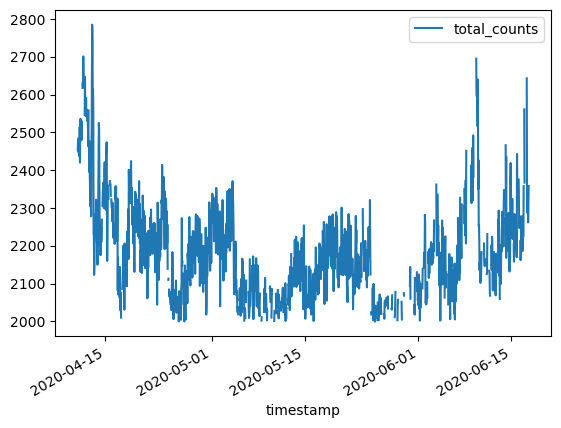

In [4]:
df['total_counts'] = crnpy.compute_total_raw_counts(df[['counts_1','counts_2','counts_3']], nan_strategy='average')

df['total_counts']=crnpy.drop_outlier(df['total_counts'], min_counts=2000, max_counts=3000)

df.plot('timestamp', 'total_counts')

In [5]:
#Find stations with cutoff rigidity similar to estimated by lat,lon
crnpy.find_neutron_detectors(crnpy.cutoff_rigidity(39.1, -96.6))

#Download data for one of the similar stations and add to df
incoming_neutrons = crnpy.get_incoming_neutron_flux(df['timestamp'], station="IRKT", utc_offset=-5)
df['incoming_flux'] = incoming_neutrons['counts']


Select a station with an altitude similar to that of your location. For more information go to: 'https://www.nmdb.eu/nest/help.php#helpstations

Your cutoff rigidity is 2.87 GV
     STID                          NAME     R  Altitude_m
42   NVBK                   Novosibirsk  2.91         163
9    CLMX                        Climax  3.00        3400
13   DRBS                       Dourbes  3.18         225
31   MCRL  Mobile Cosmic Ray Laboratory  2.46         200
33   MOSC                        Moscow  2.43         200
40   NEWK                        Newark  2.40          50
28  KIEL2                        KielRT  2.36          54
27   KIEL                          Kiel  2.36          54
32   MGDN                       Magadan  2.10         220
21   IRKT                       Irkustk  3.64         435
Check time resolution, or try the interpolate_incoming_neutron_flux() method.


In [6]:
# Fill NaN values in atmospheric data
df[['pressure', 'RH', 'T']] = crnpy.fill_missing_atm(df[['pressure', 'RH', 'T']])

# Correct count by atmospheric variables and incoming flux
df['corrected']=crnpy.atm_correction(counts=df['total_counts'], pressure=df['pressure'], humidity=df['RH'], temp=df['T'], Pref=df['pressure'].mean(), Aref=0, L=130, incoming_neutrons=df['incoming_flux']).dropna() 
df['counts']=crnpy.fill_counts(df['corrected'])
df['counts']=crnpy.drop_outlier(df['counts'], min_counts=2000, max_counts=3000)


Using median count time as expected count time: 3600.0
Discarded counts below 2000: 3
Discarded counts above 3000: 1
Discarded 66 outliers using modified Z-score.


C:\Users\jperaza\Anaconda3\envs\crnpy\lib\site-packages\crnpy\crnpy.py:356: UserWarning: Reference incoming neutron flux not provided. Using first value of incoming neutron flux.
  warnings.warn('Reference incoming neutron flux not provided. Using first value of incoming neutron flux.')
C:\Users\jperaza\Anaconda3\envs\crnpy\lib\site-packages\crnpy\crnpy.py:107: UserWarning: No count time columns provided. Using timestamp index to compute count time.
  warnings.warn("No count time columns provided. Using timestamp index to compute count time.")


<AxesSubplot: xlabel='timestamp'>

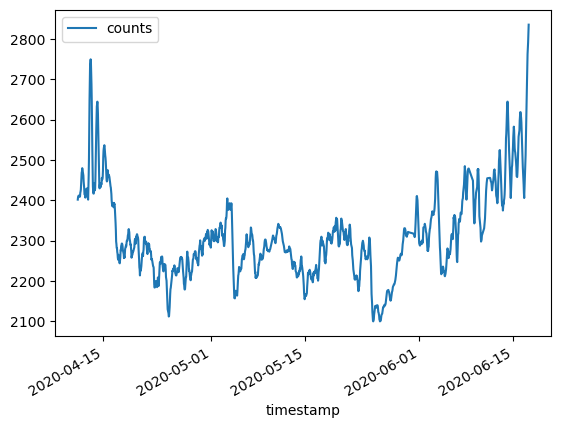

In [7]:
# Filter using the Savitzky-Golay filter
df_filtered = crnpy.smooth_counts(df['counts'].dropna(), window=17, order=3)

df_filtered.plot()

<AxesSubplot: xlabel='timestamp'>

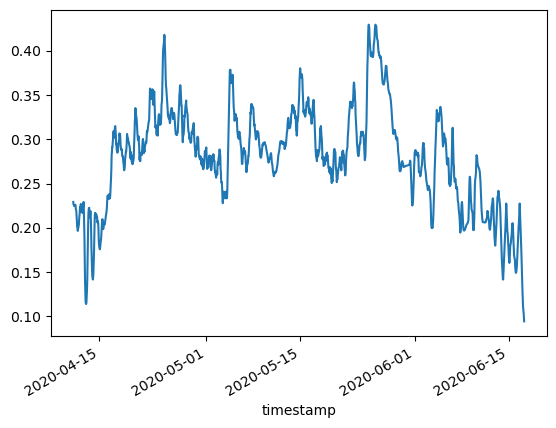

In [8]:
df['VWC']=crnpy.counts_to_vwc(df_filtered['counts'], N0=1300*3, bulk_density=1.3, Wlat=0.03, Wsoc=0.01)
df['VWC']=crnpy.fill_missing_vwc(df['VWC'])
df['VWC'].plot()

In [1]:
pip install ../

Processing c:\users\jperaza\documents\github\crnpy
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for crnpy: filename=crnpy-0.2.post21-py3-none-any.whl size=17030 sha256=317870aa3df96df1877d83abb38a0003cab3bcdacfa302b9493b8a65a8585074
  Stored in directory: C:\Users\jperaza\AppData\Local\Temp\pip-ephem-wheel-cache-8gabu2py\wheels\d8\04\95\b868552af5a02038c74b7d525df4e271ffe1b5454347a1cc19
Successfully built crnpy
Note: you may need to restart the kernel to use updated packages.
